# AutoML NLP Classifier with Confussion matrix
> AutoML NLP Classifier with Confussion matrix bigger than 10x10

- toc: true
- badges: true
- comments: true
- categories: jupyter
- image: images/chart-preview.png

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
print(tf.__version__)



## Multiclass text

This notebook shows how to predict an existing trained model using AutoML NLP, in order to manually get bigger than 10x10 confussion matrix.

We will use a [public dataset about Stack Overflow questions](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) available in Google Cloud marketplace, that has been trained using AutoML NLP. You can explore the dataset in [BigQuery](https://cloud.google.com/bigquery/) just by following the instructions of the former link. In this notebook,the model is already built and deployed in AutoML NLP service. To keep things simple our pre-processed table includes questions containing 4 possible programming-related tags: Java, Javascript, Python or C#. Confussion matrix bigger than 10x10 will be implied.

### Download the BigQuery dataset

BigQuery has a  public dataset that includes more than 17 million Stack Overflow questions. We are going to download some posts labeled as one of the four most used languages today: java, javascript, python and C#, but to make this a harder problem to our model, we have replaced every instance of that word with another less used language today (but well-known some decades ago) called `blank`. Otherwise, it will be very easy for the model to detect that a post is a java-related post just by finding the word `java` on it.

You can access the pre-processed fortran-filled dataset as a tar file [here](PENDING). Each of the four labels has approximate 10k samples for training/eval and 10k samples for test.


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
# Batch predict for an already trained AutoML NLP model

from google.cloud import automl

project_id = "windy-site-254307"
model_id = "TCN627409922111307776"
input_uri = "gs://stackoverflow-automl-nlp/dataset_batchpredict.csv"
output_uri = "gs://stackoverflow-automl-nlp"

prediction_client = automl.PredictionServiceClient()

# Get the full path of the model.
model_full_id = prediction_client.model_path(
    project_id, "us-central1", model_id
)

gcs_source = automl.types.GcsSource(input_uris=[input_uri])

input_config = automl.types.BatchPredictInputConfig(gcs_source=gcs_source)
gcs_destination = automl.types.GcsDestination(output_uri_prefix=output_uri)
output_config = automl.types.BatchPredictOutputConfig(
    gcs_destination=gcs_destination
)

response = prediction_client.batch_predict(
    model_full_id, input_config, output_config
)

print("Waiting for operation to complete...")
print(
    "Batch Prediction results saved to Cloud Storage bucket. {}".format(
        response.result()
    )
)

In [ ]:
# Download rsults. See first line for reference
# !gsutil cat gs://stackoverflow-automl-nlp/prediction-stackoverflow_4labels_20200602-2020-06-29T08:49:31.326Z/text_classification_1.jsonl  | head -1

In [ ]:
# Work in progress. Process results

#import pandas as pd
#df = pd.read_json("./text_classification_1.jsonl", lines=True)

#df['annotations'].to_list()[0]

#df['textSnippet'].to_list()[0]

#for annotation in df['annotations'].to_list()
#    print(annotation)

In [7]:
#from sklearn.metrics import confusion_matrix
#import numpy as np
#y_true = ["java", "javascript", "csharp", "java", "java", "python", "csharp", "chsarp", "java", "python", "csharp", "chsarp"]
#y_pred = ["java", "java", "csharp", "java", "java", "python", "csharp", "chsarp", "java", "python", "csharp", "chsarp"]
#matrix = confusion_matrix(y_true, y_pred, labels=["java", "javascript", "csharp", "python"])

#conf_max_12x12 = confusion_matrix(y_train, y_train_pred)
conf_max_12x12=([[1000,     3,     24,    9,    10,   49,   49,   50,   26,   23,   12,   98 ],
                [  23,  2000,     24,    9,    10,   49,   49,   50,   26,   23,   12,   98 ],
                [  56,     3,   1300,    9,    10,   49,   49,   50,   26,   23,   12,   98 ],
                [  23,     3,     24, 1400,    10,   49,   49,   50,   26,   23,   12,   98 ],
                [  35,     3,     24,    9,  1500,   49,   49,   50,   26,   23,   12,   98 ],
                [  35,     3,     24,    9,    10, 1400,   49,   50,   26,   23,   12,   98 ], 
                [  35,     3,     24,    9,    10,   49, 1300,   50,   26,   23,   12,   98 ], 
                [  35,     3,     24,    9,    10,   49,   49, 1200,   26,   23,   12,   98 ], 
                [  35,     3,     24,    9,    10,   49,   49,   50, 1100,   23,   12,   98 ], 
                [  35,     3,     24,    9,    10,   49,   49,   50,   26, 1000,   12,   98 ], 
                [  35,     3,     24,    9,    10,   49,   49,   50,   26,   23, 1100,   98 ], 
                [  35,     3,     24,    9,    10,   49,   49,   50,   26,   23,   12, 1200 ]])

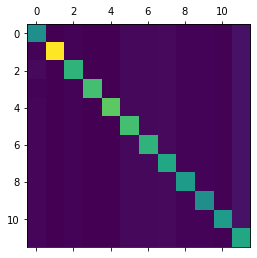

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
plt.matshow(conf_max_12x12)